
# LQR Demo

A demonstration of a simple linear quadratic regulator in 2D.


In [1]:

# Get imports
import pandas as pd
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Request high dpi, inline figures
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 200


In [2]:
def lqr(A, B, Q, R):
    """Solve for the optimal infinite-horizon LQR gain matrix
    
    Args:
        A (numpy array): MxM Linear state dynamics matrix
        B (numpy array): MxN Linear control dynamics matrix
        Q (numpy array): MxM Quadratic state cost matrix
        R (numpy array): NxN Quadratic control cost matrix
    
    Returns:
        (numpy array): NxM Infinite horizon discrete LQR gain matrix
    """
    
    # Check matrix dimensions
    assert A.shape[0] == A.shape[1], "A matrix is not square"
    assert Q.shape[0] == Q.shape[1], "Q matrix is not square"
    assert R.shape[0] == R.shape[1], "R matrix is not square"
    
    num_states = A.shape[0]
    num_controls = B.shape[1]

    assert B.shape[0] == num_states, "B matrix is incorrect shape"
    assert Q.shape[0] == num_states, "Q matrix is incorrect size"
    assert R.shape[0] == num_controls, "R matrix is incorrect size"
    
    # Solve the Discrete Algebraic Ricatti Equation
    M = scipy.linalg.solve_discrete_are(A, B, Q, R)

    # K = ((B'MB + R) ** -1) * (B'MA)
    return np.dot(
        scipy.linalg.inv(
            np.dot(np.dot(B.T, M), B) +
            R
        ),
        np.dot(np.dot(B.T, M), A)
    )


In [3]:

# Define a simple LQR system

# M State dimensions
num_states = 4
x, vx, y, vy = range(num_states)

# N Action dimensions
num_actions = 2
ax, ay = range(num_actions)

dt = 0.1
goal_state = np.array([4, 0, 0, 0])

# MxM Linear Dynamical System state matrix
A = np.array([
    [1, dt,  0,  0],
    [0,  1,  0,  0],
    [0,  0,  1, dt],
    [0,  0,  0,  1],
])

# MxN LDS control matrix
B = np.array([
    [0,  0],
    [dt, 0],
    [0,  0],
    [0, dt],
])

# Mx1 Constant state offset
C = -goal_state.T

# Nx1 Contant control/acceleration offset
D = np.array([[0, -9.81]]).T

# MxM Quadratic state cost matrix
Q = np.eye(num_states)

# NxN Quadratic control cost matrix
R = np.eye(num_actions)

def integrate(x0, pi, num_steps=500):
    """Inteagrate a policy and start state into a trajectory"""
    traj = np.array([x0.copy() + C])
    for step in range(num_steps):
        x = traj[-1, :]
        u = pi(x)
        x_prime = A.dot(x) + B.dot(u + np.squeeze(D))
        traj = np.vstack((traj, x_prime))
    return traj - C


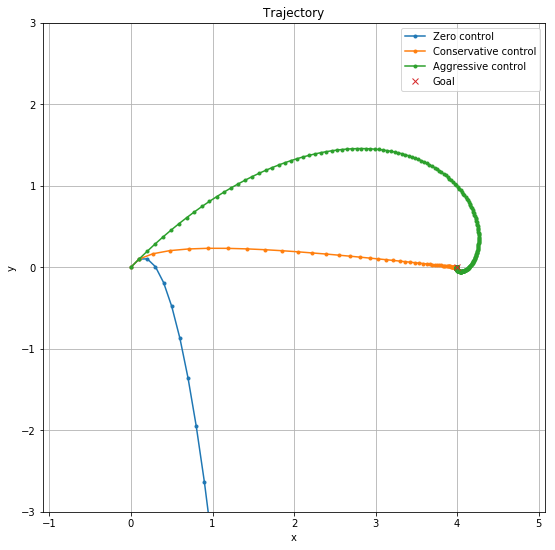

In [4]:

s0 = np.zeros(num_states)
s0[vy] = 1
s0[vx] = 1

plt.figure(figsize=(9, 9))

# Plot free-fall trajectory
traj_ff = integrate(s0, lambda s: np.zeros(num_actions))
plt.plot(
    traj_ff[:, x],
    traj_ff[:, y],
    'C0.-',
    label='Zero control'
)

# Plot conservative trajectory
k_agg = lqr(A, B, Q, 0.1 * R)
traj_agg = integrate(s0, lambda s: -k_agg.dot(s) - np.squeeze(D))
plt.plot(
    traj_agg[:, x],
    traj_agg[:, y],
    'C1.-',
    label='Conservative control'
)

# Plot aggressive trajectory
k_agg = lqr(A, B, Q, 100 * R)
traj_agg = integrate(s0, lambda s: -k_agg.dot(s) - np.squeeze(D))
plt.plot(
    traj_agg[:, x],
    traj_agg[:, y],
    'C2.-',
    label='Aggressive control'
)

# Plot goal
plt.plot(*goal_state[[x, y]], 'C3x', label='Goal')

plt.xlabel("x")
plt.ylabel("y")
plt.title("Trajectory")
plt.axis("equal")
plt.xlim((-1, 5))
plt.ylim((-3, 3))
plt.grid()
plt.legend()
plt.show()
